# Laboratorium: Autoenkodery

## Pobranie danych

In [1]:
import tensorflow as tf
import pickle 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
dataset = tf.keras.datasets.mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = dataset
X_train_full = X_train_full.astype(np.float32) / 255 
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]


## 2.1 Autoenkoder z warstwami gęstymi

### Głęboki autoenkonder zdolny do reprezentowania obrazów cyfr

In [3]:
print(X_train[0].shape)

(28, 28)


In [4]:
encoder = tf.keras.Sequential([
    tf.keras.layers.Input([28, 28]),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='selu'), # funckja selu ma wlasciwosc: samonormalizacja
    tf.keras.layers.Dense(30, activation='selu')
])



decoder = tf.keras.Sequential([
    tf.keras.layers.Input([30]),
    tf.keras.layers.Dense(100, activation='selu'),
    tf.keras.layers.Dense(28*28, activation='sigmoid'),
    tf.keras.layers.Reshape([28,28])
])

ae = tf.keras.Sequential([encoder, decoder])


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, )
ae.compile(optimizer=optimizer, loss=tf.keras.losses.Huber() , 
           metrics=['mae']) # mae - mean absolute error



In [7]:
history = ae.fit(X_train, X_train, epochs=5, 
                 validation_data=(X_valid, X_valid))


Epoch 1/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0212 - mae: 0.1054 - val_loss: 0.0085 - val_mae: 0.0498
Epoch 2/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0082 - mae: 0.0484 - val_loss: 0.0070 - val_mae: 0.0432
Epoch 3/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0068 - mae: 0.0420 - val_loss: 0.0062 - val_mae: 0.0391
Epoch 4/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0061 - mae: 0.0387 - val_loss: 0.0058 - val_mae: 0.0374
Epoch 5/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0056 - mae: 0.0366 - val_loss: 0.0054 - val_mae: 0.0358


In [ ]:
ae.evaluate(X_test, X_test, return_dict=True)

# {'loss': 0.005280734039843082, 'mae': 0.03514503315091133}

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0055 - mae: 0.0359


{'loss': 0.005280734039843082, 'mae': 0.03514503315091133}

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


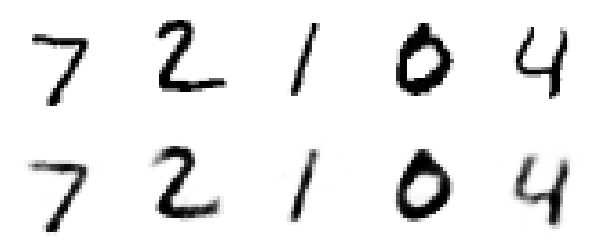

In [11]:
def plot_reconstructions(model, images=X_test, n_images=5):
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images*1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1+image_index)
        plt.imshow(images[image_index], cmap='binary')
        plt.axis('off')
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap='binary')
        plt.axis('off')

plot_reconstructions(ae)


In [ ]:
ae.save('ae_stacked.keras')


## 2.2 Autoenkoder konwolucyjny

In [18]:
conv_encoder = tf.keras.Sequential([
    tf.keras.layers.Input([28, 28]),
    tf.keras.layers.Reshape([28, 28, 1]),
    tf.keras.layers.Conv2D(16, kernel_size=3, padding='same', 
                           activation='selu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(32, kernel_size=3, padding='same', 
                           activation='selu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(64, kernel_size=3, padding='same', 
                           activation='selu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
])

conv_decoder = tf.keras.models.Sequential([
    tf.keras.layers.Input([3, 3, 64]),
    tf.keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2,
                                    padding='valid', activation='selu'),
    tf.keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2,
                                    padding='same', activation='selu'),
    tf.keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2,
                                    padding='same', activation='sigmoid'),
    tf.keras.layers.Reshape([28, 28])
])


In [19]:
conv_ae = tf.keras.Sequential([conv_encoder, conv_decoder])


In [20]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
conv_ae.compile(optimizer=optimizer, 
                loss=tf.keras.losses.Huber(), 
                metrics=['mae'])


In [21]:
history = conv_ae.fit(X_train, X_train, epochs=5,
                      validation_data=(X_valid, X_valid))


Epoch 1/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - loss: 0.0240 - mae: 0.0975 - val_loss: 0.0037 - val_mae: 0.0282
Epoch 2/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 0.0033 - mae: 0.0265 - val_loss: 0.0027 - val_mae: 0.0241
Epoch 3/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - loss: 0.0025 - mae: 0.0227 - val_loss: 0.0023 - val_mae: 0.0213
Epoch 4/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 0.0021 - mae: 0.0206 - val_loss: 0.0019 - val_mae: 0.0199
Epoch 5/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 0.0018 - mae: 0.0192 - val_loss: 0.0017 - val_mae: 0.0187


In [ ]:
conv_ae.evaluate(X_test, X_test)
# [0.0016590015729889274, 0.018200533464550972]


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0017 - mae: 0.0182


[0.0016590015729889274, 0.018200533464550972]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


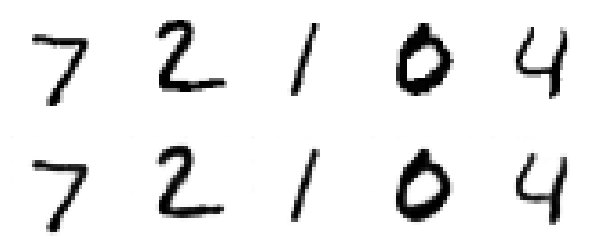

In [23]:
plot_reconstructions(conv_ae)
plt.show()

In [24]:
conv_ae.save('ae_conv.keras')

## 2.3 Wizualizacja wyników

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


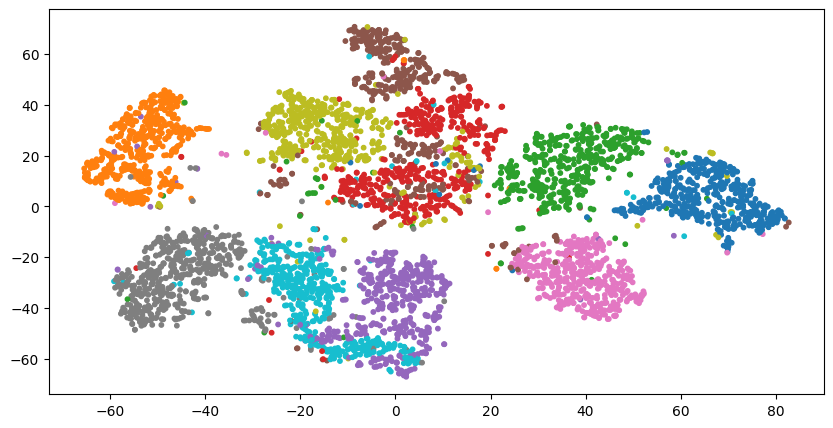

In [27]:
from sklearn.manifold import TSNE

X_valid_compressed = conv_encoder.predict(X_valid)

n_samples , x, y, z = X_valid_compressed.shape
X_valid_compressed_flat = X_valid_compressed.reshape((n_samples, x*y*z))

tsne = TSNE(init="pca", learning_rate="auto", random_state=42)
X_valid_2D = tsne.fit_transform(X_valid_compressed_flat)

plt.figure(figsize=(10, 5))
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.show()


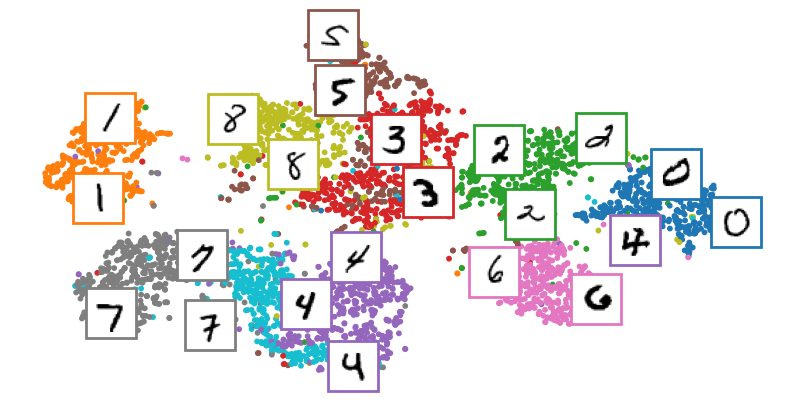

In [29]:
import matplotlib as mpl


plt.figure(figsize=(10, 5))
cmap = plt.cm.tab10
Z = X_valid_2D
Z = (Z - Z.min()) / (Z.max() - Z.min()) # normalize to the 0-1 range
plt.scatter(Z[:, 0], Z[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(Z):
    dist = ((position - image_positions) ** 2).sum(axis=1)
    if dist.min() > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)


plt.axis("off")
plt.show()



## 2.4 Odszumianie

### Gausian Noise

In [30]:
gausian_noise_encoder = tf.keras.Sequential([
    tf.keras.layers.Input([28,28]),
    tf.keras.layers.Flatten(),
    tf.keras.layers.GaussianNoise(stddev=0.15),
    tf.keras.layers.Dense(100, activation='selu'),
    tf.keras.layers.Dense(30, activation='selu')
])

gausian_noise_decoder = tf.keras.Sequential([
    tf.keras.layers.Input([30]),
    tf.keras.layers.Dense(100, activation='selu'),
    tf.keras.layers.Dense(28*28, activation='sigmoid'),
    tf.keras.layers.Reshape([28,28])
])

gae = tf.keras.Sequential([gausian_noise_encoder, gausian_noise_decoder])


In [31]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
gae.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])


In [32]:
history = gae.fit(X_train, X_train, epochs=5, validation_data=(X_valid, X_valid))


Epoch 1/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0211 - mae: 0.1052 - val_loss: 0.0088 - val_mae: 0.0525
Epoch 2/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0091 - mae: 0.0520 - val_loss: 0.0076 - val_mae: 0.0465
Epoch 3/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0079 - mae: 0.0467 - val_loss: 0.0066 - val_mae: 0.0421
Epoch 4/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0070 - mae: 0.0428 - val_loss: 0.0061 - val_mae: 0.0393
Epoch 5/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0066 - mae: 0.0409 - val_loss: 0.0059 - val_mae: 0.0382


In [ ]:
gae.evaluate(X_test, X_test)
# [0.005728995893150568, 0.03739464282989502]


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0059 - mae: 0.0380


[0.005728995893150568, 0.03739464282989502]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


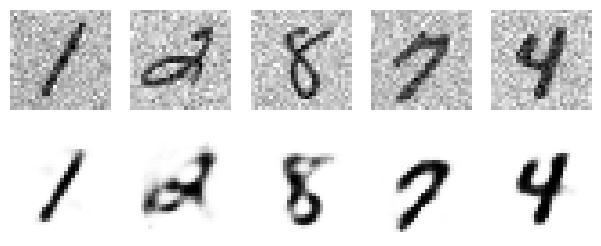

In [34]:
gausian_noise = tf.keras.layers.GaussianNoise(stddev=0.15)
plot_reconstructions(gae, gausian_noise(X_valid, training=True))


### Dropout

In [35]:
dropout_encoder = tf.keras.models.Sequential([
    tf.keras.layers.Input([28,28]),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(100, activation='selu'),
    tf.keras.layers.Dense(30, activation='selu'),
])

dropout_decoder = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, activation='selu'),
    tf.keras.layers.Dense(28*28, activation='sigmoid'),
    tf.keras.layers.Reshape([28,28])
])

dae = tf.keras.models.Sequential([dropout_encoder, dropout_decoder])


In [36]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
dae.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer,
            metrics=['mae'])


In [38]:
history = dae.fit(X_train, X_train, epochs=5, 
        validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0118 - mae: 0.0639 - val_loss: 0.0086 - val_mae: 0.0539
Epoch 2/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0105 - mae: 0.0579 - val_loss: 0.0078 - val_mae: 0.0491
Epoch 3/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0097 - mae: 0.0542 - val_loss: 0.0074 - val_mae: 0.0475
Epoch 4/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0092 - mae: 0.0521 - val_loss: 0.0070 - val_mae: 0.0459
Epoch 5/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0089 - mae: 0.0504 - val_loss: 0.0068 - val_mae: 0.0438


In [ ]:
dae.evaluate(X_test, X_test)
# [0.006634000223129988, 0.043030720204114914]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0068 - mae: 0.0436


[0.006634000223129988, 0.043030720204114914]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


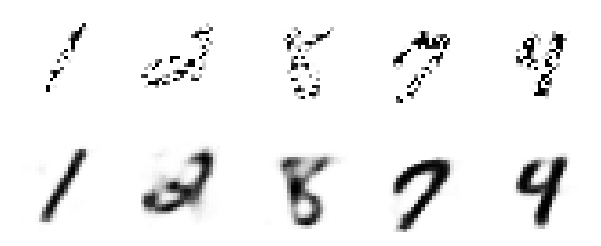

In [40]:
dropout = tf.keras.layers.Dropout(0.5)
plot_reconstructions(dae, dropout(X_valid, training=True))


In [ ]:
dae.save('ae_denoise.keras')